In [1]:
from tqdm import tqdm, trange
import os, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.myutils import *
from utils.gcnutils import *

import tensorflow as tf
import tf_geometric as tfg
from tf_geometric.utils import tf_utils



# 1.读入GCN数据表

In [2]:
# 读入数据信息
dat  = pd.read_csv("/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_fin622v.csv", encoding = 'utf-8', low_memory=False)##VGG6+CBAM模型构造的GCN数据表
#dat  = pd.read_csv("/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_622v.csv", encoding = 'utf-8', low_memory=False)# # VGG6模型构造的GCN数据表
#dat  = pd.read_csv("/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_SA2_622v.csv", encoding = 'utf-8', low_memory=False) # VGG16+spatial attention模型构造的GCN数据表
#dat  = pd.read_csv("/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_CA2_622v.csv", encoding = 'utf-8', low_memory=False) # VGG16+channel attention模型构造的GCN数据表
print("病人数: ", len(dat["ID"].unique()), "结节数: ", len(dat["nID"].unique()), ", 切片数: ", dat.shape[0])
dat.loc[dat["nID"]==1, ]


病人数:  426 结节数:  483 , 切片数:  10863


,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,502,503,504,505,506,507,508,509,510,511
16,10,365,375,106,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.271494,0.0,0.001086,0.0,0.730265,3.427443,0.0,0.173296,1.301743,0.0
17,10,365,375,107,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.487855,0.0,0.000000,0.0,0.288661,3.485277,0.0,0.565462,1.582984,0.0
18,10,365,375,108,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.162848,0.0,0.000000,0.0,0.206439,3.047782,0.0,1.145101,1.434289,0.0
19,10,365,375,109,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.720697,0.0,0.002221,0.0,0.143737,3.369864,0.0,0.493168,1.485426,0.0
20,10,365,375,110,左肺,下叶,混杂密度,MIA,NaN,0.8,...,2.144575,0.0,0.021033,0.0,0.313045,3.116035,0.0,0.349208,2.000945,0.0
21,10,365,375,111,左肺,下叶,混杂密度,MIA,NaN,0.8,...,2.416321,0.0,0.000000,0.0,0.355153,3.106383,0.0,0.196834,1.892239,0.0
22,10,365,375,112,左肺,下叶,混杂密度,MIA,NaN,0.8,...,2.120743,0.0,0.000000,0.0,0.337172,3.670469,0.0,0.097100,1.597055,0.0
23,10,365,375,113,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.784855,0.0,0.000000,0.0,0.203459,3.283871,0.0,0.620029,1.691860,0.0
24,10,365,375,114,左肺,下叶,混杂密度,MIA,NaN,0.8,...,2.051986,0.0,0.000000,0.0,0.260246,3.248288,0.0,0.666258,1.520430,0.0
25,10,365,375,115,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.642739,0.0,0.000000,0.0,0.168641,3.609444,0.0,0.869618,1.431197,0.0


# 2.结节切片数量选择
结节切片数量的选择策略有以下两种

In [3]:
dat_cut = cutDF(dat, 5)  # 策略1：每个结节挑选中间5张切片作为模型输入
#dat_cut=dat  # 策略2：每个结节挑选全部切片作为模型输入
print("病人数:",len(dat_cut["ID"].unique()),"dat 结节数: ", len(dat_cut["nID"].unique()), ", 切片数: ", dat_cut.shape[0])
dat_cut.loc[dat_cut["nID"]==1, ]

病人数: 424 dat 结节数:  479 , 切片数:  2395


,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,502,503,504,505,506,507,508,509,510,511
5,10,365,375,109,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.720697,0.0,0.002221,0.0,0.143737,3.369864,0.0,0.493168,1.485426,0.0
6,10,365,375,110,左肺,下叶,混杂密度,MIA,NaN,0.8,...,2.144575,0.0,0.021033,0.0,0.313045,3.116035,0.0,0.349208,2.000945,0.0
7,10,365,375,111,左肺,下叶,混杂密度,MIA,NaN,0.8,...,2.416321,0.0,0.000000,0.0,0.355153,3.106383,0.0,0.196834,1.892239,0.0
8,10,365,375,112,左肺,下叶,混杂密度,MIA,NaN,0.8,...,2.120743,0.0,0.000000,0.0,0.337172,3.670469,0.0,0.097100,1.597055,0.0
9,10,365,375,113,左肺,下叶,混杂密度,MIA,NaN,0.8,...,1.784855,0.0,0.000000,0.0,0.203459,3.283871,0.0,0.620029,1.691860,0.0


# 3.划分训练集、验证集、测试集
#### 复现特征提取部分的划分情况

In [4]:
IDs = pd.read_csv("/mnt/GCNxin/output.csv", encoding = 'utf-8', low_memory=False)
IDs

,train_IDs,valid_IDs,test_IDs
0,98,63.0,191.0
1,626,268.0,543.0
2,589,380.0,177.0
3,454,183.0,267.0
4,231,375.0,540.0
...,...,...,...
250,173,NaN,NaN
251,436,NaN,NaN
252,595,NaN,NaN
253,621,NaN,NaN


In [5]:
train_IDs_list = IDs['train_IDs'].dropna().astype(int).tolist() #将病人ID删除缺失值后以整数型数据保存为列表
test_IDs_list = IDs['test_IDs'].dropna().astype(int).tolist()
valid_IDs_list = IDs['valid_IDs'].dropna().astype(int).tolist()
train_IDs_listzong=train_IDs_list+valid_IDs_list # 获取训练集和验证集病人ID序列和
print(train_IDs_list)
print(test_IDs_list)
print(valid_IDs_list)
# 提取符合条件的切片，即 dat_cut DataFrame 中 ID 列属于 train_IDs_list 的切片
#train_slices = dat_cut[dat_cut['ID'].isin(train_IDs_list)]
#train_slices.reset_index(drop=True, inplace=True)
type(test_IDs_list)
len(train_IDs_listzong)

[98, 626, 589, 454, 231, 230, 119, 163, 568, 398, 461, 404, 444, 84, 284, 549, 574, 627, 562, 27, 312, 85, 510, 339, 203, 414, 580, 297, 519, 498, 400, 132, 298, 350, 402, 176, 430, 317, 114, 555, 167, 250, 333, 448, 55, 458, 281, 480, 272, 26, 277, 289, 299, 417, 296, 547, 566, 603, 273, 438, 354, 346, 386, 31, 511, 429, 310, 201, 550, 325, 295, 393, 249, 142, 171, 168, 399, 150, 185, 453, 258, 44, 366, 77, 497, 136, 394, 565, 587, 321, 349, 373, 304, 33, 66, 504, 544, 396, 523, 356, 599, 293, 209, 324, 329, 248, 166, 413, 422, 487, 144, 408, 336, 83, 90, 237, 22, 484, 631, 303, 502, 241, 216, 331, 283, 145, 632, 48, 246, 431, 172, 121, 35, 623, 184, 53, 598, 614, 352, 327, 579, 462, 360, 158, 219, 467, 612, 611, 357, 501, 524, 180, 575, 178, 68, 42, 266, 337, 343, 30, 622, 456, 530, 538, 29, 397, 257, 577, 139, 76, 286, 583, 131, 236, 395, 443, 18, 122, 368, 234, 425, 529, 221, 170, 433, 164, 481, 88, 572, 213, 592, 243, 278, 37, 32, 548, 485, 308, 154, 56, 471, 188, 156, 316, 446, 3

340

In [6]:

def psplitDF8(data, col_name, reset, train_IDs, test_IDs, seed=12, shuffle=True):
    # 得到两个数据集
    train_dat = data.loc[data[col_name].isin(train_IDs), ]  # 训练集
    test_dat = data.loc[data[col_name].isin(test_IDs), ]  # 测试集
    if reset == True:  # 判断是在划分训练集和测试集，还是在划分训练集和验证集
        train_dat = train_dat.reset_index(drop=True)  # 重设索引为连续的整数，从0开始
        test_dat = test_dat.reset_index(drop=True)
        train_index = list(range(len(train_dat)))  # 更新 train_index，使用range函数生成从0开始的连续整数序列
        test_index = list(range(len(test_dat)))  # 更新 test_index，使用range函数生成从0开始的连续整数序列
    else:
        # 提取索引，用于模型训练
        train_index = train_dat.index.tolist()  # 训练集索引
        test_index = test_dat.index.tolist()  # 测试集索引
    # 返回训练集表、测试集表、训练集表索引、测试集表索引
    return train_dat, test_dat, train_index, test_index


In [7]:
train_dat, test_dat, _, test_index = psplitDF8(dat_cut, "ID",  train_IDs=train_IDs_listzong,test_IDs= test_IDs_list, reset=True)  # 按病人ID划分为训练集和测试集
len(train_dat)
_, _, train_index, valid_index = psplitDF8(train_dat, "ID", train_IDs=train_IDs_list,test_IDs= valid_IDs_list,reset=False)  # 按病人ID将训练集再划分为训练集和验证集
print(f"训练数据中训练集{pcalRate(train_dat, train_index)}")
print(f"训练数据中验证集{pcalRate(train_dat, valid_index)}")
print(f"测试数据中测试集{pcalRate(test_dat, test_index)}")
print(f"训练集: {train_index}")
print(f"验证集: {valid_index}")
print(f"测试集: {test_index[:5]}")
len(train_index)
len(valid_index)

训练数据中训练集切片数: 6578，微乳头切片占比: 38.81%，结节数: 291, 微乳头结节占比：31.2%，病人数: 255
训练数据中验证集切片数: 2278，微乳头切片占比: 34.77%，结节数: 99, 微乳头结节占比：31.0%，病人数: 85
测试数据中测试集切片数: 2007，微乳头切片占比: 40.01%，结节数: 93, 微乳头结节占比：28.35%，病人数: 86
训练集: [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

2278

# 4.构建图
#### 以无向图（即双向边）的方式来创建索引关系，再对每个病人（以ID为key）构建子图，包括三种构图方式：
##### 1.链状图：每个结节从底部切片向顶部切片进行连接，构成一个链式图；
##### 2.星形图：每个结节从结节中心切片向其他切片进行连接，构成一个星形图；
##### 3.全连接图：所有结节互相连接。

In [7]:
# 以病人ID划分子图，默认以dat的后512列作为特征矩阵
# 星状图
train_graph, train_edges = createGraph(train_dat, "nID", "star")  # 训练集和验证集的图和边
test_graph, test_edges = createGraph(test_dat, "nID", "star")  # 测试集的图和边
## 链状图
#train_graph, train_edges = createGraph(train_dat, "nID", "linear")  # 训练集和验证集的图和边
#test_graph, test_edges = createGraph(test_dat, "nID", "linear")  # 测试集的图和边
## 全连接图
#train_graph, train_edges = createGraph(train_dat, "nID", "full")  # 训练集和验证集的图和边
#test_graph, test_edges = createGraph(test_dat, "nID", "full")  # 测试集的图和边
print("训练集和验证集构成的图：", train_graph)
print("测试集构成的图：", test_graph)
train_edges.tail(10)
# test_edges.tail(10)

训练集和验证集构成的图： Graph Shape: x => (1905, 512)	edge_index => (2, 3048)	y => (1905,)
测试集构成的图： Graph Shape: x => (490, 512)	edge_index => (2, 784)	y => (490,)


,source,target
3038,1893,1892
3039,1894,1892
3040,1895,1897
3041,1896,1897
3042,1898,1897
3043,1899,1897
3044,1900,1902
3045,1901,1902
3046,1903,1902
3047,1904,1902


# 5.构建GCN模型
#### 设置基本参数，模型预测的类别数量为2，dropout率为0.3，学习率为0.0001。

In [8]:
num_classes = train_graph.y.max() + 1
drop_rate = 0.3
#learning_rate = 1e-2
learning_rate = 0.0001
print(f"类别数: {num_classes}, 类别: {np.unique(train_graph.y)}")

类别数: 2, 类别: [0 1]


#### 通过tf_geometric库中提供的功能对GCN进行了实现，注意模型中设置了隐藏层维度 𝑝0=32 。

In [9]:
class GCNModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(32, activation=tf.nn.relu)# 创建一个GCN层，命名为gcn0，其中包含32个输出单元，激活函数为ReLU。
        self.gcn1 = tfg.layers.GCN(num_classes) #创建另一个GCN层，命名为gcn1，其中的输出单元数量由num_classes指定，用于图分类任务
        self.dropout = tf.keras.layers.Dropout(drop_rate) #创建一个Dropout层

    def call(self, inputs, training=None, mask=None, cache=None):#定义模型的前向传播方法
        x, edge_index, edge_weight = inputs #节点特征矩阵x、图的边索引edge_index 和边权重edge_weight作为输入
        h = self.dropout(x, training=training) #对输入节点特征进行Dropout操作
        h = self.gcn0([h, edge_index, edge_weight], cache=cache) #使用第一个GCN层进行图卷积操作
        h = self.dropout(h, training=training) #对第一个GCN层的输出进行Dropout操作
        h = self.gcn1([h, edge_index, edge_weight], cache=cache) #使用第二个GCN层进行图卷积操作
        return h

In [10]:
# 模型实例化
model = GCNModel()

2023-12-30 08:31:30.284482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-30 08:31:30.839742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15405 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:1f:00.0, compute capability: 6.0


# 6.训练准备
##### 这一部分中将完成训练GCN时所需要的一系列准备工作，定义包括计算损失函数、训练模型、模型评估等函数，定义模型的优化器。需要注意的是，这一部分中，各个函数均为模板，并不要求自己完成这些函数。其中，@tf_utils.function的作为在于能够使2.0+版本的TensorFlow在进行训练模型时得到加速。

In [11]:
# 只有在GCN模型使用@tf_utils.function时需要添加此行
model.gcn0.build_cache_for_graph(train_graph)
# 设置优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [12]:
# 模型保存
checkpoint_dir = "./model/GCNxin/ft2/"+time.strftime('%Y-%m-%d')  # GNN模型保存路径
checkpoint_prefix = "gcn"  # GNN模型保存文件前缀
# 创建一个检查点
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
# 检查点管理器
##Checkpoint 只保存模型的参数，不保存模型的计算过程
##因此一般用于在具有模型源代码的时候恢复之前训练好的模型参数。如果需要导出模型(无需源代码也能运行模型)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_dir, max_to_keep=20, checkpoint_name=checkpoint_prefix)  # 最多保留20个最新的检查点文件

# 7.训练模型
##### 训练200个epoch，每10个epoch汇报一次训练集上的损失函数和验证集上的准确率。

In [13]:
%%time
epochs = 200  # 训练epoch数
best_epoch = 0  # 取得最佳验证精度的epoch
best_acc = 0  # 最佳验证精度

# 在训练数据上进行训练
for epoch in range(1, epochs+1):
    loss = train_step(model, train_graph, optimizer, train_index)  # 训练集loss
    if epoch % 10 == 0:  # 每10个epoch进行一次模型评估
        trian_accuracy = evaluate(model, train_graph, train_index)  # 训练集精度
        val_accuracy = evaluate(model, train_graph, valid_index)  # 验证集精度
        print("epoch = {} \t train_loss = {:.10g} \t train_accuracy = {:.10g} \t valid_accuracy = {:.10g}".format(
            epoch, loss, trian_accuracy, val_accuracy))
        if val_accuracy > best_acc:
            best_epoch = epoch  # 更新取得最佳验证精度的epoch
            best_acc = val_accuracy  # 更新最佳验证精度
            # 保存最佳模型
#             checkpoint.save(file_prefix=os.path.join(checkpoint_dir, checkpoint_prefix))  # 保存当前状态，同时保留之前的所有检查点
            manager.save()  # 保存当前状态，只保留最新的部分检查点
            print("write checkpoint at epoch {}".format(epoch))
print(f"验证集上在第{best_epoch}个epoch取得最佳精度: {best_acc}")

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:1", shape=(1425,), dtype=int32), values=Tensor("PartitionedCall:0", shape=(1425, 2), dtype=float32), dense_shape=Tensor("PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2023-12-30 08:31:34.974550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


epoch = 10 	 train_loss = 1.354829669 	 train_accuracy = 0.2701754272 	 valid_accuracy = 0.28125
write checkpoint at epoch 10
epoch = 20 	 train_loss = 1.009468198 	 train_accuracy = 0.287017554 	 valid_accuracy = 0.275000006
epoch = 30 	 train_loss = 0.820940733 	 train_accuracy = 0.448421061 	 valid_accuracy = 0.3833333254
write checkpoint at epoch 30
epoch = 40 	 train_loss = 0.6531598568 	 train_accuracy = 0.7410526276 	 valid_accuracy = 0.6625000238
write checkpoint at epoch 40
epoch = 50 	 train_loss = 0.5927214026 	 train_accuracy = 0.7733333111 	 valid_accuracy = 0.7208333611
write checkpoint at epoch 50
epoch = 60 	 train_loss = 0.5673584342 	 train_accuracy = 0.7887719274 	 valid_accuracy = 0.7354166508
write checkpoint at epoch 60
epoch = 70 	 train_loss = 0.5036685467 	 train_accuracy = 0.8014035225 	 valid_accuracy = 0.7375000119
write checkpoint at epoch 70
epoch = 80 	 train_loss = 0.4784721136 	 train_accuracy = 0.823859632 	 valid_accuracy = 0.7729166746
write checkpoi

# 8.模型评估
##### 平均法：
##### 利用每个切片的预测概率，取均值得到每个结节的预测得分，再根据最大预测得分得到预测分类，对应acc为[ACC_argmax]

Confusion matrix, without normalization
[[1220   50]
 [ 175  625]]
Confusion matrix, without normalization
[[66  3]
 [ 6 21]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.891304,0.960630,0.781250,0.925926,0.874552,0.847458,0.891304,0.954550
结节级,0.906250,0.956522,0.777778,0.875000,0.916667,0.823529,0.906250,0.944176


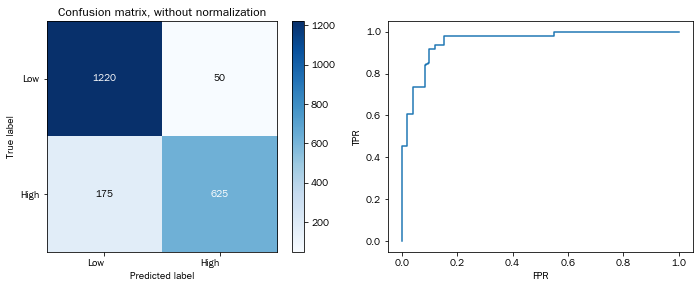

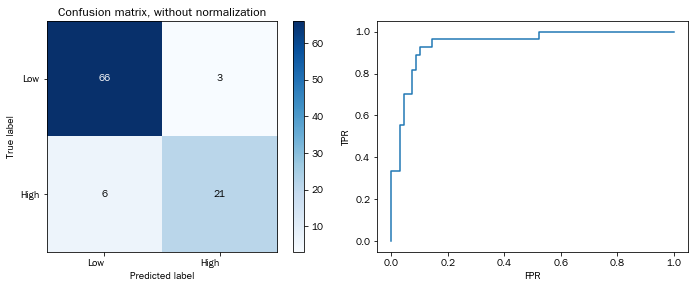

In [14]:
# 在训练数据的验证集上进行评估(全部切片+全连接图 all full)
y_true, y_pred, y_value = getPreds(model, train_graph, valid_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(train_dat, valid_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Accuracy:0.9100
Area under the ROC curve : 0.970064
26    0.627766
Name: thresholds, dtype: float32
Confusion matrix, without normalization
[[1282   48]
 [  60  877]]
Confusion matrix, without normalization
[[63  3]
 [ 3 31]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.95236,0.963910,0.935966,0.948108,0.955291,0.941998,0.910013,0.970064
结节级,0.94000,0.954545,0.911765,0.911765,0.954545,0.911765,0.910000,0.956774


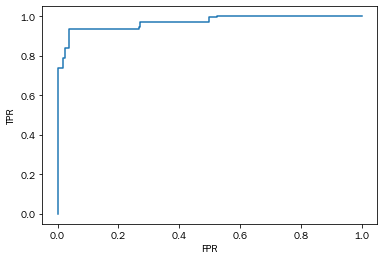

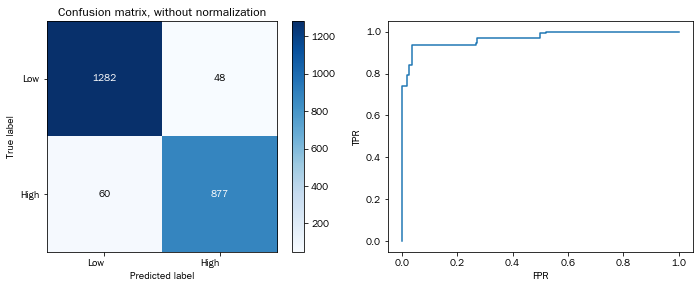

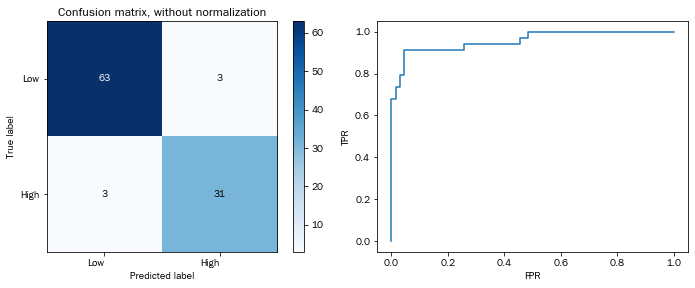

In [15]:
# 在测试集上进行评估(全部切片+全连接图 all full)
model.gcn0.build_cache_for_graph(test_graph)
y_true, y_pred, y_value = getPreds(model, test_graph, test_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[1165  105]
 [ 244  556]]
Confusion matrix, without normalization
[[67  2]
 [ 9 18]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.831401,0.917323,0.695000,0.84115,0.826828,0.761123,0.831401,0.900230
结节级,0.885417,0.971014,0.666667,0.90000,0.881579,0.765957,0.895833,0.935051


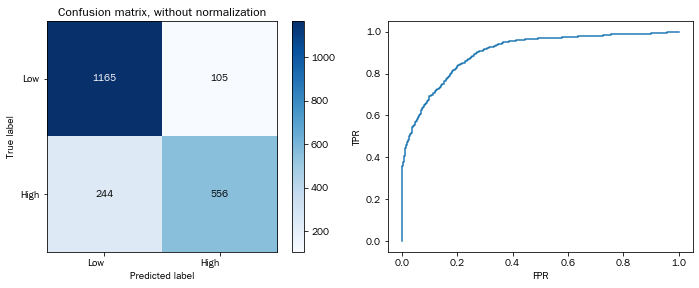

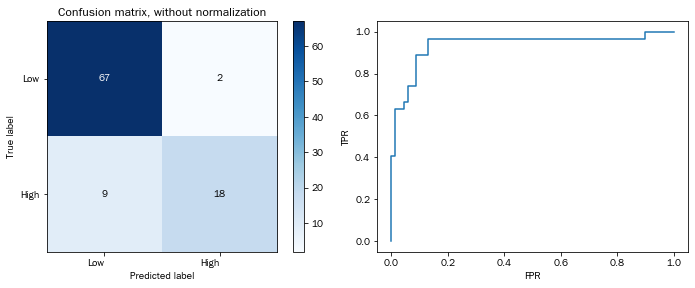

In [14]:
# 在训练数据的验证集上进行评估(全部切片+链状图 all linear) 
y_true, y_pred, y_value = getPreds(model, train_graph, valid_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(train_dat, valid_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[1199  131]
 [ 307  630]]
Confusion matrix, without normalization
[[64  2]
 [12 22]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.806793,0.901504,0.672359,0.827858,0.796149,0.742049,0.806793,0.898755
结节级,0.860000,0.969697,0.647059,0.916667,0.842105,0.758621,0.870000,0.946970


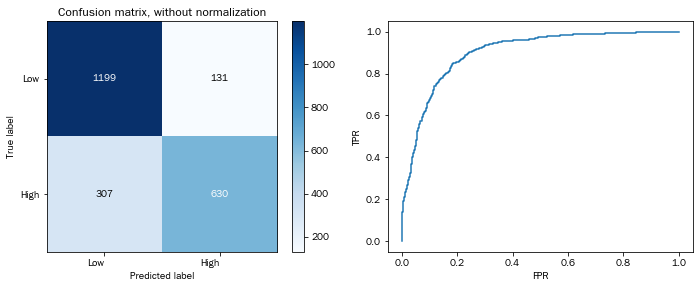

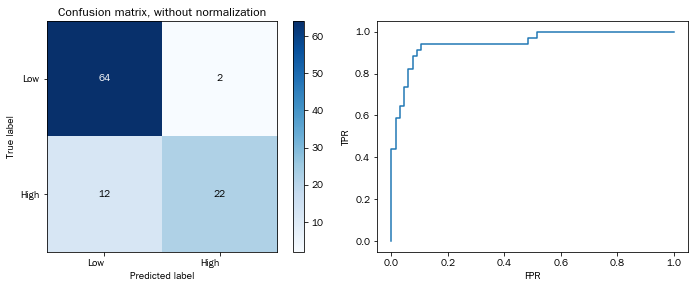

In [15]:
# 在测试数据上进行评估(全部切片+链状图 all linear) 
model.gcn0.build_cache_for_graph(test_graph)
y_true, y_pred, y_value = getPreds(model, test_graph, test_index)  # 真实标签、预测标签、预测结果

# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[1226   44]
 [ 109  691]]
Confusion matrix, without normalization
[[66  3]
 [ 5 22]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.926087,0.965354,0.863750,0.940136,0.918352,0.900326,0.926087,0.969437
结节级,0.916667,0.956522,0.814815,0.880000,0.929577,0.846154,0.916667,0.962963


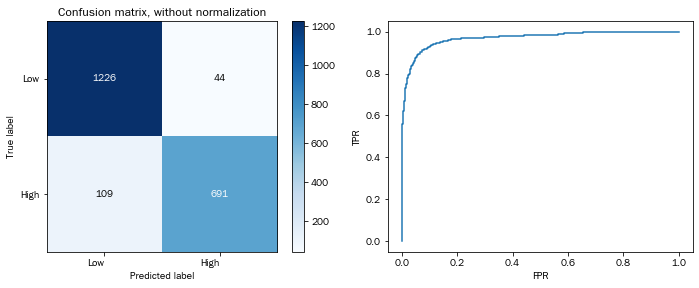

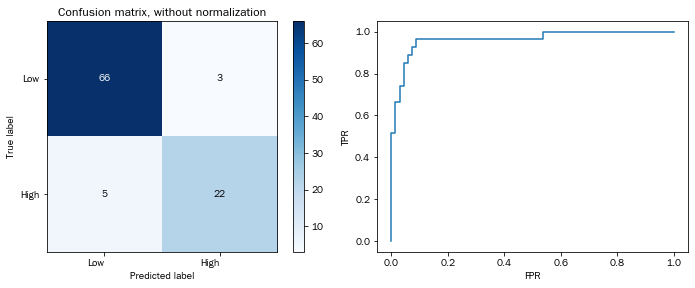

In [15]:
# 在训练数据的验证集上进行评估(全部切片+星状图 all star) 
y_true, y_pred, y_value = getPreds(model, train_graph, valid_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(train_dat, valid_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[1234   96]
 [ 192  745]]
Confusion matrix, without normalization
[[63  3]
 [ 9 25]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.87296,0.927820,0.795091,0.885850,0.865358,0.838020,0.87296,0.935688
结节级,0.88000,0.954545,0.735294,0.892857,0.875000,0.806452,0.89000,0.943405


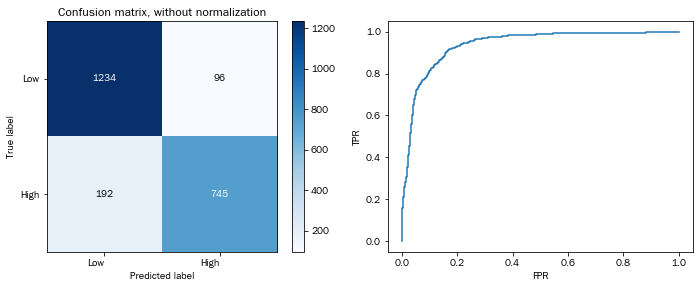

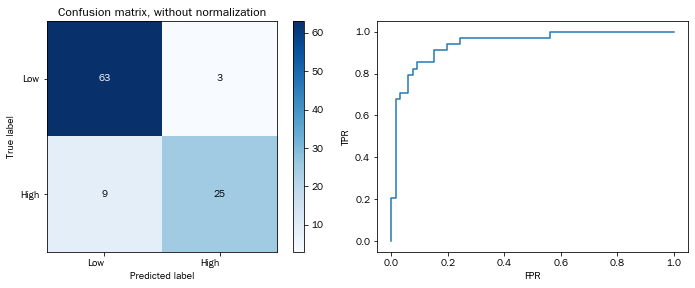

In [16]:
# 在测试数据上进行评估(全部切片+星状图 all star) 
model.gcn0.build_cache_for_graph(test_graph)
y_true, y_pred, y_value = getPreds(model, test_graph, test_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
#metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
#metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[345   0]
 [ 30 105]]
Confusion matrix, without normalization
[[69  0]
 [ 6 21]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.9375,1.0,0.777778,1.0,0.92,0.875,0.9375,0.973849
结节级,0.9375,1.0,0.777778,1.0,0.92,0.875,0.9375,0.973698


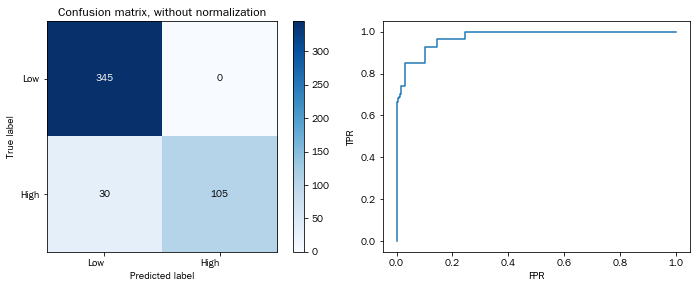

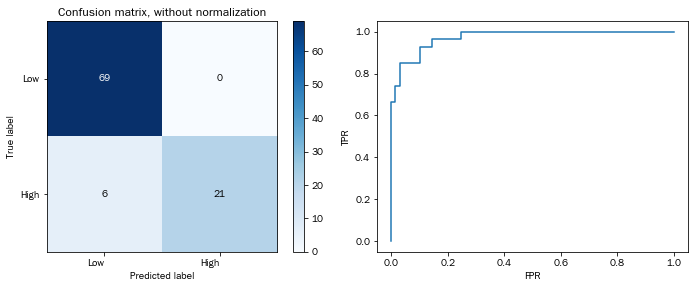

In [15]:
# 在训练数据的验证集上进行评估(5张切片+全连接图5full) 
y_true, y_pred, y_value = getPreds(model, train_graph, valid_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(train_dat, valid_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[305  15]
 [ 60 110]]
Confusion matrix, without normalization
[[61  3]
 [12 22]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.846939,0.953125,0.647059,0.88,0.835616,0.745763,0.846939,0.921213
结节级,0.846939,0.953125,0.647059,0.88,0.835616,0.745763,0.846939,0.920956


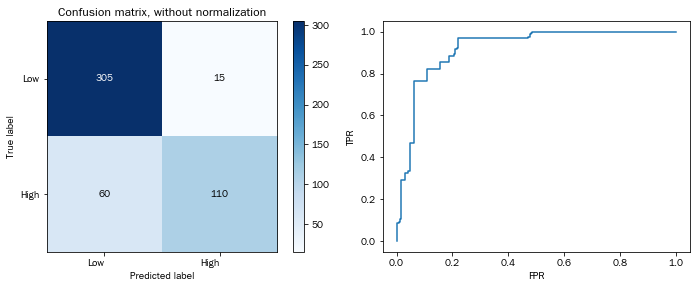

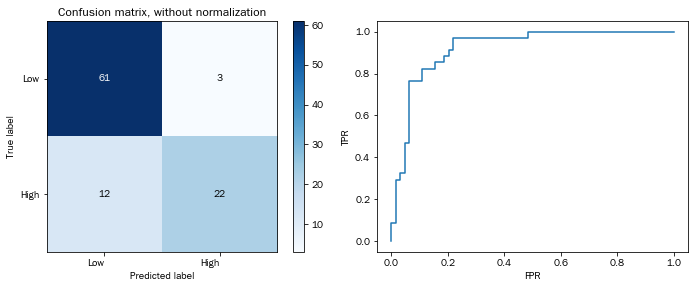

In [16]:
# 在测试数据上进行评估(5张切片+全连接图5full) 
model.gcn0.build_cache_for_graph(test_graph)
y_true, y_pred, y_value = getPreds(model, test_graph, test_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[333  12]
 [ 64  71]]
Confusion matrix, without normalization
[[67  2]
 [13 14]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.841667,0.965217,0.525926,0.855422,0.838791,0.651376,0.841667,0.923135
结节级,0.843750,0.971014,0.518519,0.875000,0.837500,0.651163,0.843750,0.930220


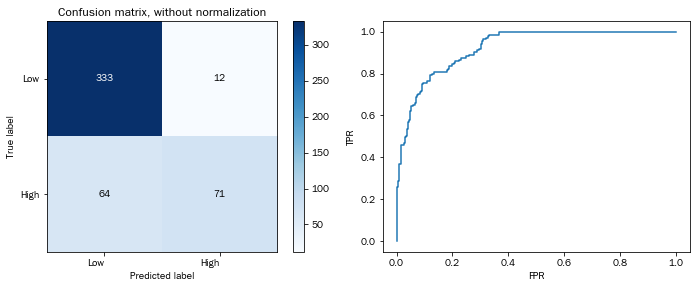

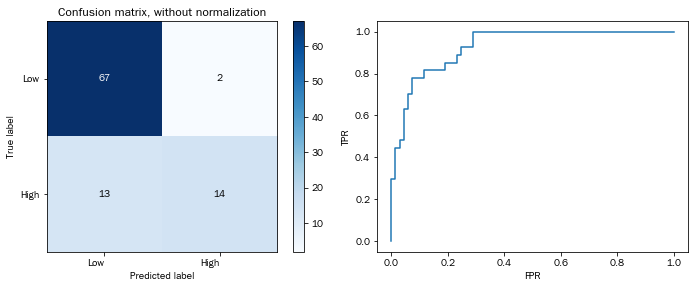

In [14]:
# 在训练数据的验证集上进行评估(5张切片+链状图5linear) 
y_true, y_pred, y_value = getPreds(model, train_graph, valid_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(train_dat, valid_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[298  22]
 [ 66 104]]
Confusion matrix, without normalization
[[59  5]
 [12 22]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.820408,0.931250,0.611765,0.825397,0.818681,0.702703,0.820408,0.905643
结节级,0.826531,0.921875,0.647059,0.814815,0.830986,0.721311,0.826531,0.914062


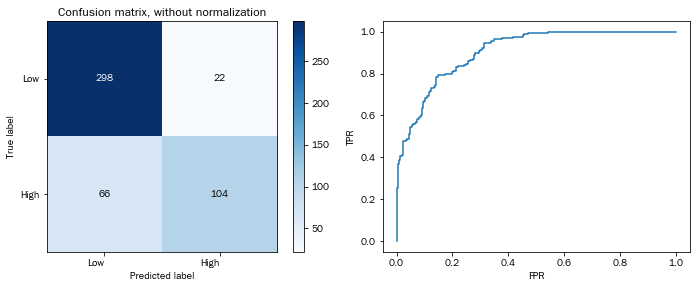

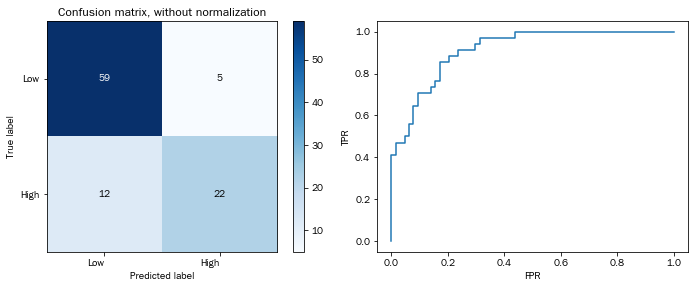

In [15]:
#### 在测试数据上进行评估(5张切片+链状图5linear) 
model.gcn0.build_cache_for_graph(test_graph)
y_true, y_pred, y_value = getPreds(model, test_graph, test_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
#metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
#metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[343   2]
 [ 50  85]]
Confusion matrix, without normalization
[[69  0]
 [ 9 18]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.891667,0.994203,0.629630,0.977011,0.872774,0.765766,0.891667,0.960000
结节级,0.906250,1.000000,0.666667,1.000000,0.884615,0.800000,0.906250,0.964573


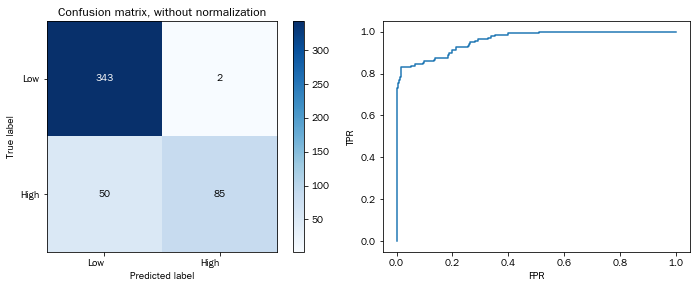

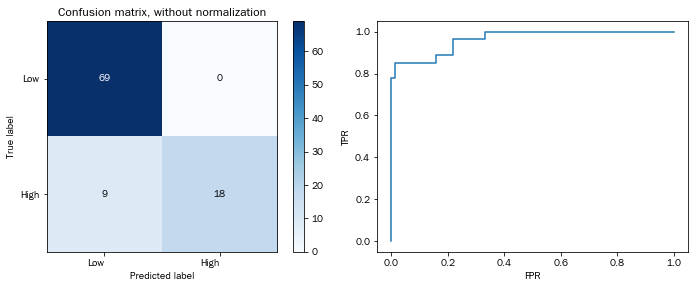

In [14]:
# 在训练数据的验证集上进行评估(5张切片+星状图5star) 
y_true, y_pred, y_value = getPreds(model, train_graph, valid_index)  # 真实标签、预测标签、预测结果

# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
metrics_nodule, thresh_nodule = metricsOnNodule(train_dat, valid_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics

Confusion matrix, without normalization
[[296  24]
 [ 69 101]]
Confusion matrix, without normalization
[[59  5]
 [13 21]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.810204,0.925000,0.594118,0.808000,0.810959,0.684746,0.810204,0.901342
结节级,0.816327,0.921875,0.617647,0.807692,0.819444,0.700000,0.806122,0.906250


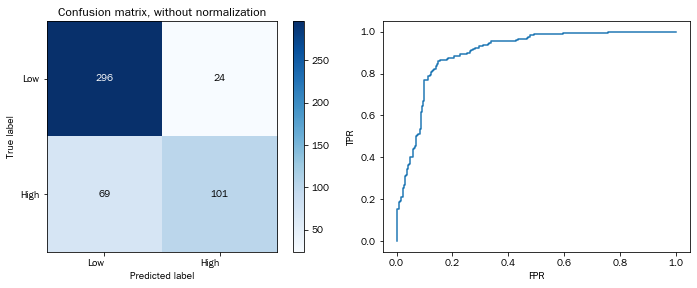

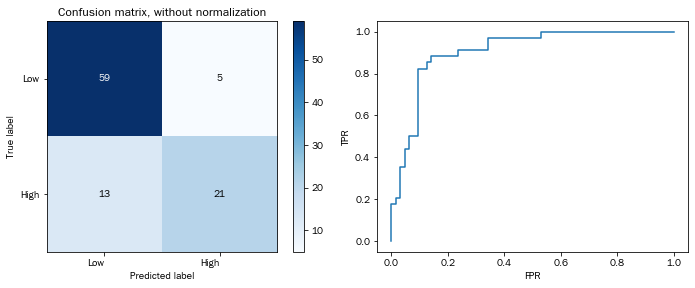

In [15]:
# 在测试数据上进行评估(5张切片+星状图5star)
model.gcn0.build_cache_for_graph(test_graph)
y_true, y_pred, y_value = getPreds(model, test_graph, test_index)  # 真实标签、预测标签、预测结果
# 转numpy
y_true = y_true.numpy()
y_pred = y_pred.numpy()
y_value = y_value.numpy()
# 实际标签取值，同时作为混淆矩阵轴标签
labels_value = np.array([0, 1])
# 切片级的相关评估指标
#metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
metrics_slices, thresh_slices = compreEval(y_true, y_pred, y_value, classes=labels_value, normalize=False);
# 结节级的相关评估指标，投票法以0.5为阈值
#metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);
metrics_nodule, thresh_nodule = metricsOnNodule(test_dat, test_index, y_pred, y_value, labels_value, pthresh=0.5);metrics = pd.concat([metrics_slices, metrics_nodule])
metrics.index = ["切片级","结节级"]
metrics